# Compiled Code


In [347]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee'])
import os
os.chdir('/Users/acannon/Dropbox')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler 

## Pillar 1

## Pillar 2 - Retail Sentiment

Creating the data points for the google trends data. I standardise the data in STATA, and conduct the PCA to get the rotations.
This is hard coded, and i do not know how to save the rotations as a string or something (need to fix)

In [259]:

std = pd.read_excel('diss_data/std_gt.xlsx')
std_rot = [-0.0268,0.4361,0.2970,0.4448,0.1754,0.0226,-0.0843,-0.1768,-0.3240,0.0958,0.2119,0.1849,0.1853,0.2209,0.0963,0.1309,0.0688,-0.2044,-0.2247,-0.1791,0.1469]
var = ["Benefits","Indeed", "Linkedin", "SkyScanner" ,"Emirates" ,"Holiday" ,"Film" ,"DIY", "Gifts" ,"Clothes" ,"Jobs" ,"Merc" ,"Toyota" ,"Resort" ,"RyanAir" ,"Museums" ,"McD", "Gucci", "LV", "Zara", "fm"]

std_new = std.filter(regex= "std")

# changing the variable names from the names created in STATA to match the variable names in the list var
for col in std_new.columns:
    if col.startswith('std_resid_'):
        new_col_name = col.split('_')[2]  # Extract the variable name
        std_new.rename(columns={col: new_col_name}, inplace=True)


In [260]:
std_w = pd.DataFrame()
for i in range(0,len(var)):
    std_w[var[i]] = std_new[var[i]]*std_rot[i]

<AxesSubplot:ylabel='trends'>

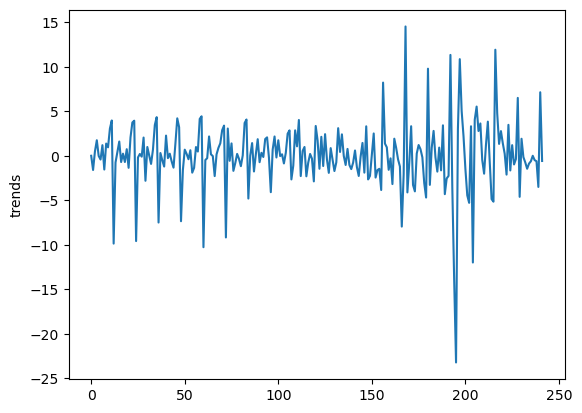

In [335]:
std_w['trends'] = std_w.sum(axis = 1)
sns.lineplot(std_w['trends'])

## Pillar 3 - LTP


<AxesSubplot:ylabel='land_pct'>

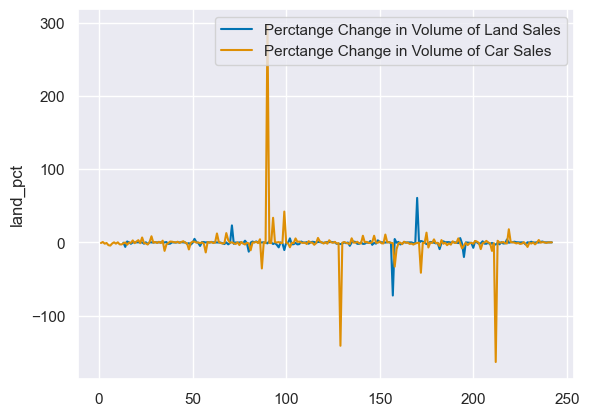

In [262]:
indicators = pd.read_excel('diss_data/more.xlsx')

# getting the long-term purchase variables from the indicator dataset

ltp = indicators[['period', 'std_land', 'std_resid_car']]

# making them numeric because they are strings atm
ltp['std_resid_car'] = pd.to_numeric(ltp['std_resid_car'], errors = 'coerce')
ltp['std_land'] = pd.to_numeric(ltp['std_land'], errors = 'coerce')

# calculate percentage change
ltp['car_pct'] = ltp['std_resid_car'].pct_change()
ltp['land_pct'] = ltp['std_land'].pct_change()
ltp['car_diff'] = ltp['std_resid_car'].diff()
ltp['land_diff'] = ltp['std_land'].diff()

sns.lineplot(ltp['land_pct'], label = 'Perctange Change in Volume of Land Sales')
sns.lineplot(ltp['car_pct'], label = 'Perctange Change in Volume of Car Sales')

Text(0, 0.5, "Car Sales ('000s)")

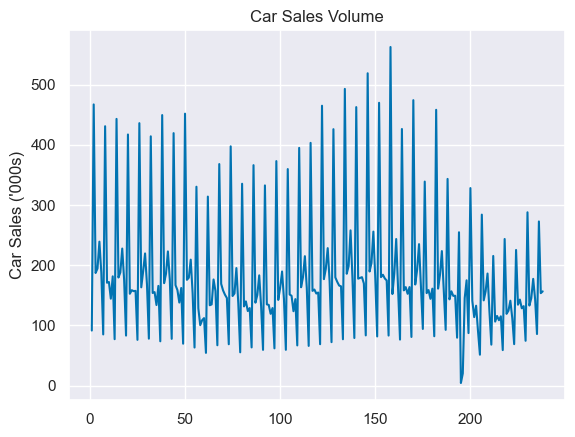

<AxesSubplot:ylabel='land_diff'>

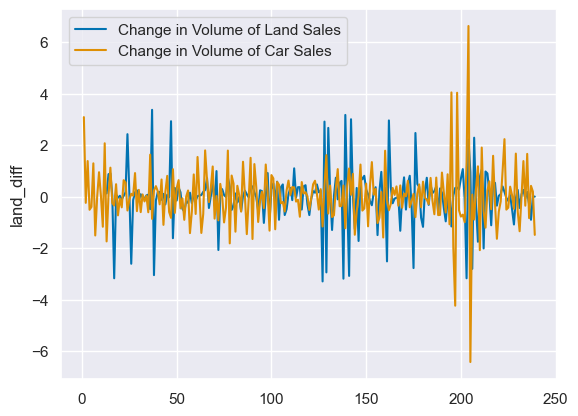

In [263]:
sns.lineplot(ltp['land_diff'], label = 'Change in Volume of Land Sales')
sns.lineplot(ltp['car_diff'], label = 'Change in Volume of Car Sales')

There is obviously massive seasonality in the car sales. Because of this I will difference the car sales volume first, then find the percentage chanegs in the differences.

Other possible options:
- Moving average -> pct_change

In [264]:
#ltp['car_diff'] = ltp['car'].diff()
#ltp['car_diff_pct'] = ltp['car_diff'].pct_change()

#sns.lineplot(ltp['car_diff_pct'])
#plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
#plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession', color = 'darkblue')
#plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession', color = 'grey')
#plt.show()

Adding the recession highlights just to get a better grasp of how the pct change in monthly change may tell us something about upcoming recessions. In the case of 2020 and 2023 there seems to be drops before the *actual* recession hits. This is not the case for 2008-9, but again we see a massive drop off about 2 years in advance (no idea what to interpret from that). The shocks in this during 2006ish and 2014ish may be do to some exogenous shocks that I am unaware of.

<AxesSubplot:ylabel='indicator3'>

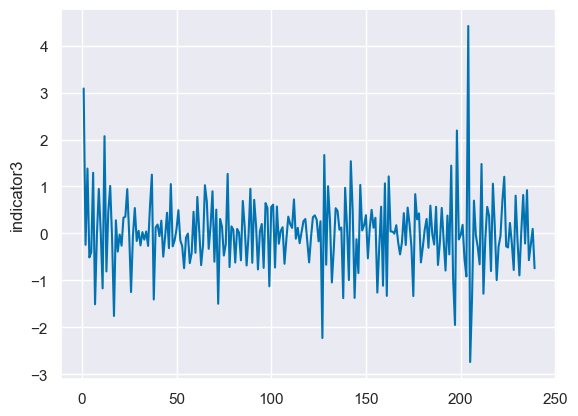

In [265]:
p3 = ltp[['car_diff','land_diff']]

p3['indicator3'] = p3[['land_diff', 'car_diff']].mean(1,skipna=True)
p3['period'] = ltp['period']

sns.lineplot(p3['indicator3'])

# Pillar 4

<AxesSubplot:ylabel='spread'>

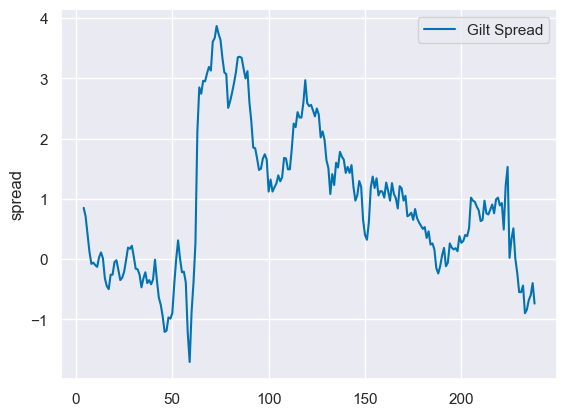

In [266]:
spread = indicators[['Y10', 'month2']]
spread['Y10'] = pd.to_numeric(spread['Y10'], errors= 'coerce')
spread['spread'] = spread['Y10'] - spread['month2']
spread['period'] = indicators['period']

sns.lineplot(spread['spread'], label = 'Gilt Spread')

In [267]:
p4 = spread[['period','spread']]

p4['indicator4'] = p4['spread']

# Pillar 5

<AxesSubplot:>

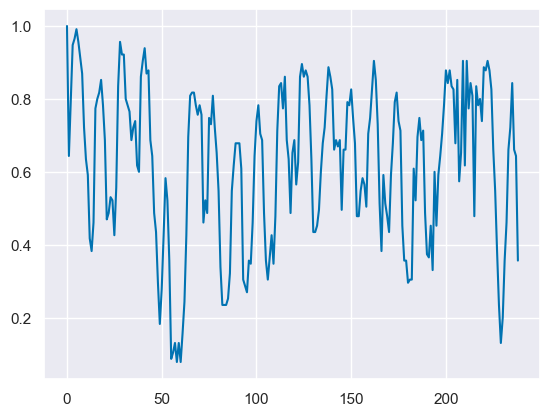

In [268]:
df_hp = pd.read_excel('diss_data/clean_hp.xlsx')
pdummy = df_hp.filter(regex = "Ip$")

pdummy.head()

diff_index = pdummy.mean(axis = 1)
diff_index.plot.line(x = df_hp['period'])

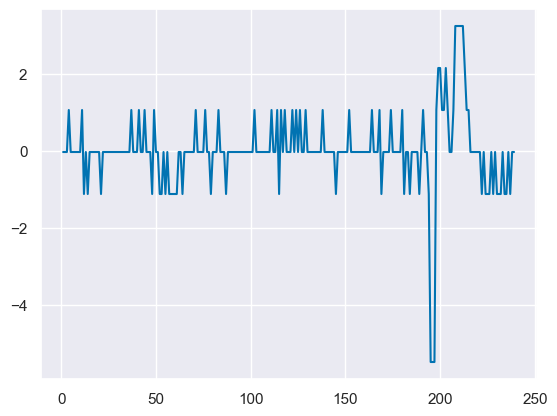

In [269]:
p5 = pd.DataFrame()
p5['vacancy'] = indicators[['all_vacancies']]
p5['vac_diff'] = p5['vacancy'].diff()
p5['period'] = indicators['period']

scaler = StandardScaler()
std_p5 = pd.DataFrame(scaler.fit_transform(p5[['vacancy','vac_diff']]), columns = [['vacancy','vac_diff']])

plt.plot(std_p5['vac_diff'])

<AxesSubplot:ylabel='indicator5'>

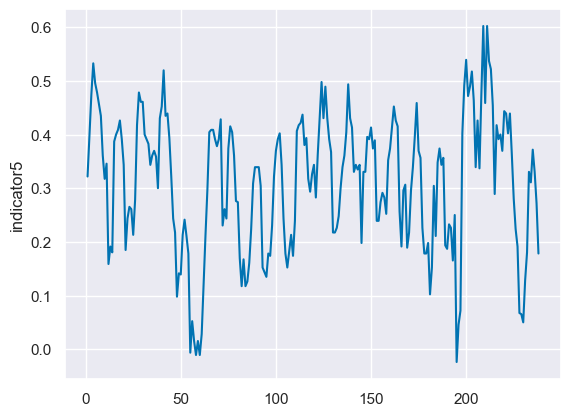

In [270]:
p5['diff_index'] = diff_index

p5['indicator5'] = 0.5 * p5['diff_index'] + 0.5 * p5['vac_diff']

sns.lineplot(p5['indicator5'])

## Constructing the Sentiment Index

In [271]:
frames = [p3,p4,p5]
SI = p4.merge(p5, how = 'left', on = 'period')
SI = SI.merge(p3, 'left', on = 'period')

In [272]:
SI.head()
SI = SI.filter(regex = r'indicator')
SI['period'] = p5['period'] 
SI['indicator2'] = std_w['trends']

In [273]:
SI['final'] = SI[['indicator2','indicator3','indicator4','indicator5']].mean(1, skipna=True)

<AxesSubplot:>

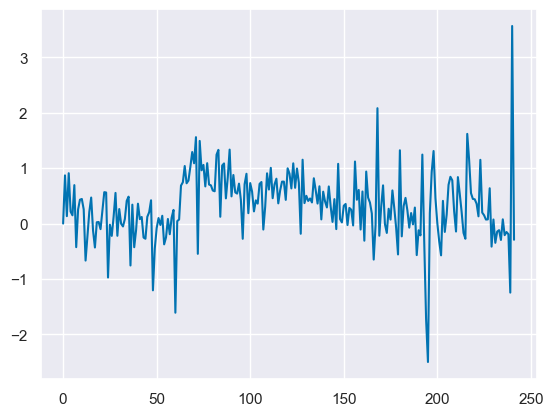

In [274]:
SI['final'].plot()

In [275]:

std_SI = pd.DataFrame(scaler.fit_transform(SI[['indicator2','indicator3','indicator4','indicator5']]), columns = [['indicator2','indicator3','indicator4','indicator5']])
std_SI['final'] = std_SI[['indicator2','indicator3','indicator4','indicator5']].mean(1, skipna=True)
std_SI['period'] = SI['period']


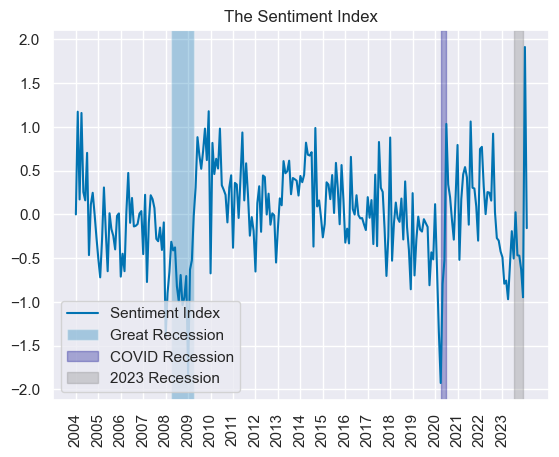

In [321]:
january_indices = [i for i in range(230) if std_SI.index[i] % 12 == 0]
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
plt.plot(std_SI['final'], label = 'Sentiment Index')
plt.xticks(january_indices, labels = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], rotation = 'vertical')
plt.title('The Sentiment Index')


# trying to add grey area for recessions
# index 0 is 2004 - 01
# 2008-01 == 48
# 2008-04 == 51
# 2008 Q2 (51) - 2009 Q2 (63)
# 2020 Q1 (195) - Q2 (198)
# 2023 Q3 (234) - Q4 (239)
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession', color = 'darkblue')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession', color = 'grey')
plt.legend(loc = 'lower left')
plt.show()

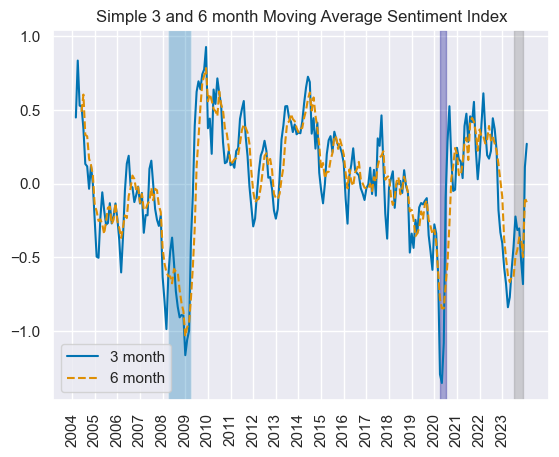

In [279]:

sma3 = std_SI['final'].rolling(3).mean()
sma6 = std_SI['final'].rolling(6).mean()
plt.plot(sma3, label = '3 month')
plt.plot(sma6, label = '6 month', linestyle = 'dashed')
plt.axvspan(51, 63, alpha = 0.3)
plt.axvspan(195, 198, alpha = 0.3, color = 'darkblue')
plt.axvspan(234, 239, alpha = 0.3, color = 'grey')
plt.xticks(january_indices, labels = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], rotation = 'vertical')
plt.title('Simple 3 and 6 month Moving Average Sentiment Index')
plt.legend(loc = 'lower left')
plt.show()

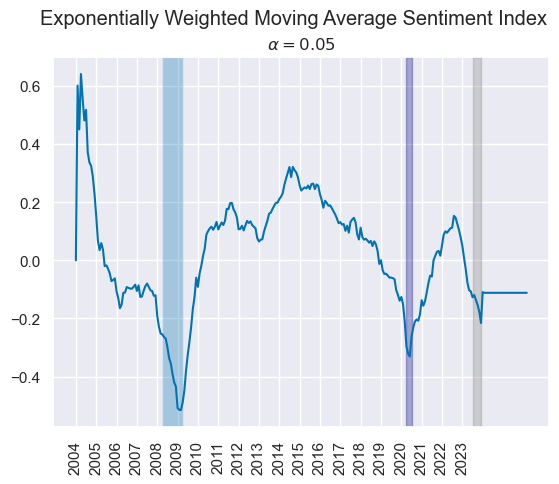

In [280]:
ema = std_SI['final'].ewm(alpha = 0.05).mean()
plt.plot(ema)
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession', color = 'darkblue')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession', color = 'grey')
plt.suptitle('Exponentially Weighted Moving Average Sentiment Index')
plt.xticks(january_indices, labels = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], rotation = 'vertical')
plt.title(r'$\alpha = 0.05$')
plt.show()

In [281]:
std_SI[['indicator2', 'indicator3','indicator4', 'indicator5']].describe()

,indicator2,indicator3,indicator4,indicator5
count,242.00,239.00,235.00,238.00
mean,-0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-6.23,-3.46,-2.22,-2.65
25%,-0.39,-0.48,-0.79,-0.74
50%,-0.00,0.01,-0.08,0.22
75%,0.47,0.52,0.58,0.74
max,3.89,5.54,2.48,2.31


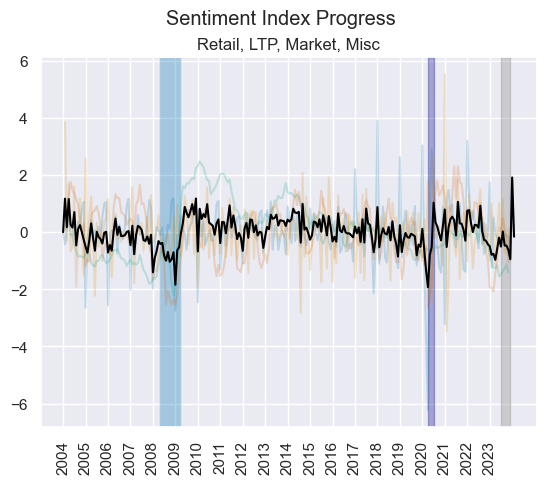

In [295]:
plt.plot(std_SI['indicator2'], alpha = 0.2)
plt.plot(std_SI['indicator3'], alpha = 0.2)
plt.plot(std_SI['indicator4'], alpha = 0.2)
plt.plot(std_SI['indicator5'], alpha = 0.2)
plt.plot(std_SI['final'], color = 'black')
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession', color = 'darkblue')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession', color = 'grey')
plt.suptitle('Sentiment Index Progress')
plt.title('Retail, LTP, Market, Misc')
plt.xticks(january_indices, labels = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], rotation = 'vertical')
plt.show()

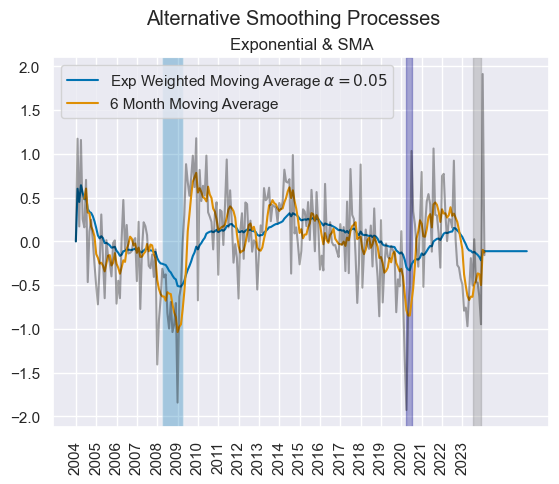

In [309]:
plt.plot(ema, label = r'Exp Weighted Moving Average $\alpha = 0.05$')
plt.plot(sma6, label = '6 Month Moving Average')
plt.plot(std_SI['final'], color = 'black', alpha = 0.35)
plt.axvspan(51, 63, alpha = 0.3)
plt.axvspan(195, 198, alpha = 0.3, color = 'darkblue')
plt.axvspan(234, 239, alpha = 0.3, color = 'grey')
plt.suptitle('Alternative Smoothing Processes')
plt.title('Exponential & SMA')
plt.xticks(january_indices, labels = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], rotation = 'vertical')
plt.legend()
plt.show()

## Comments on the graph/Sentiment Index as it stands

## Graphs for dissertation

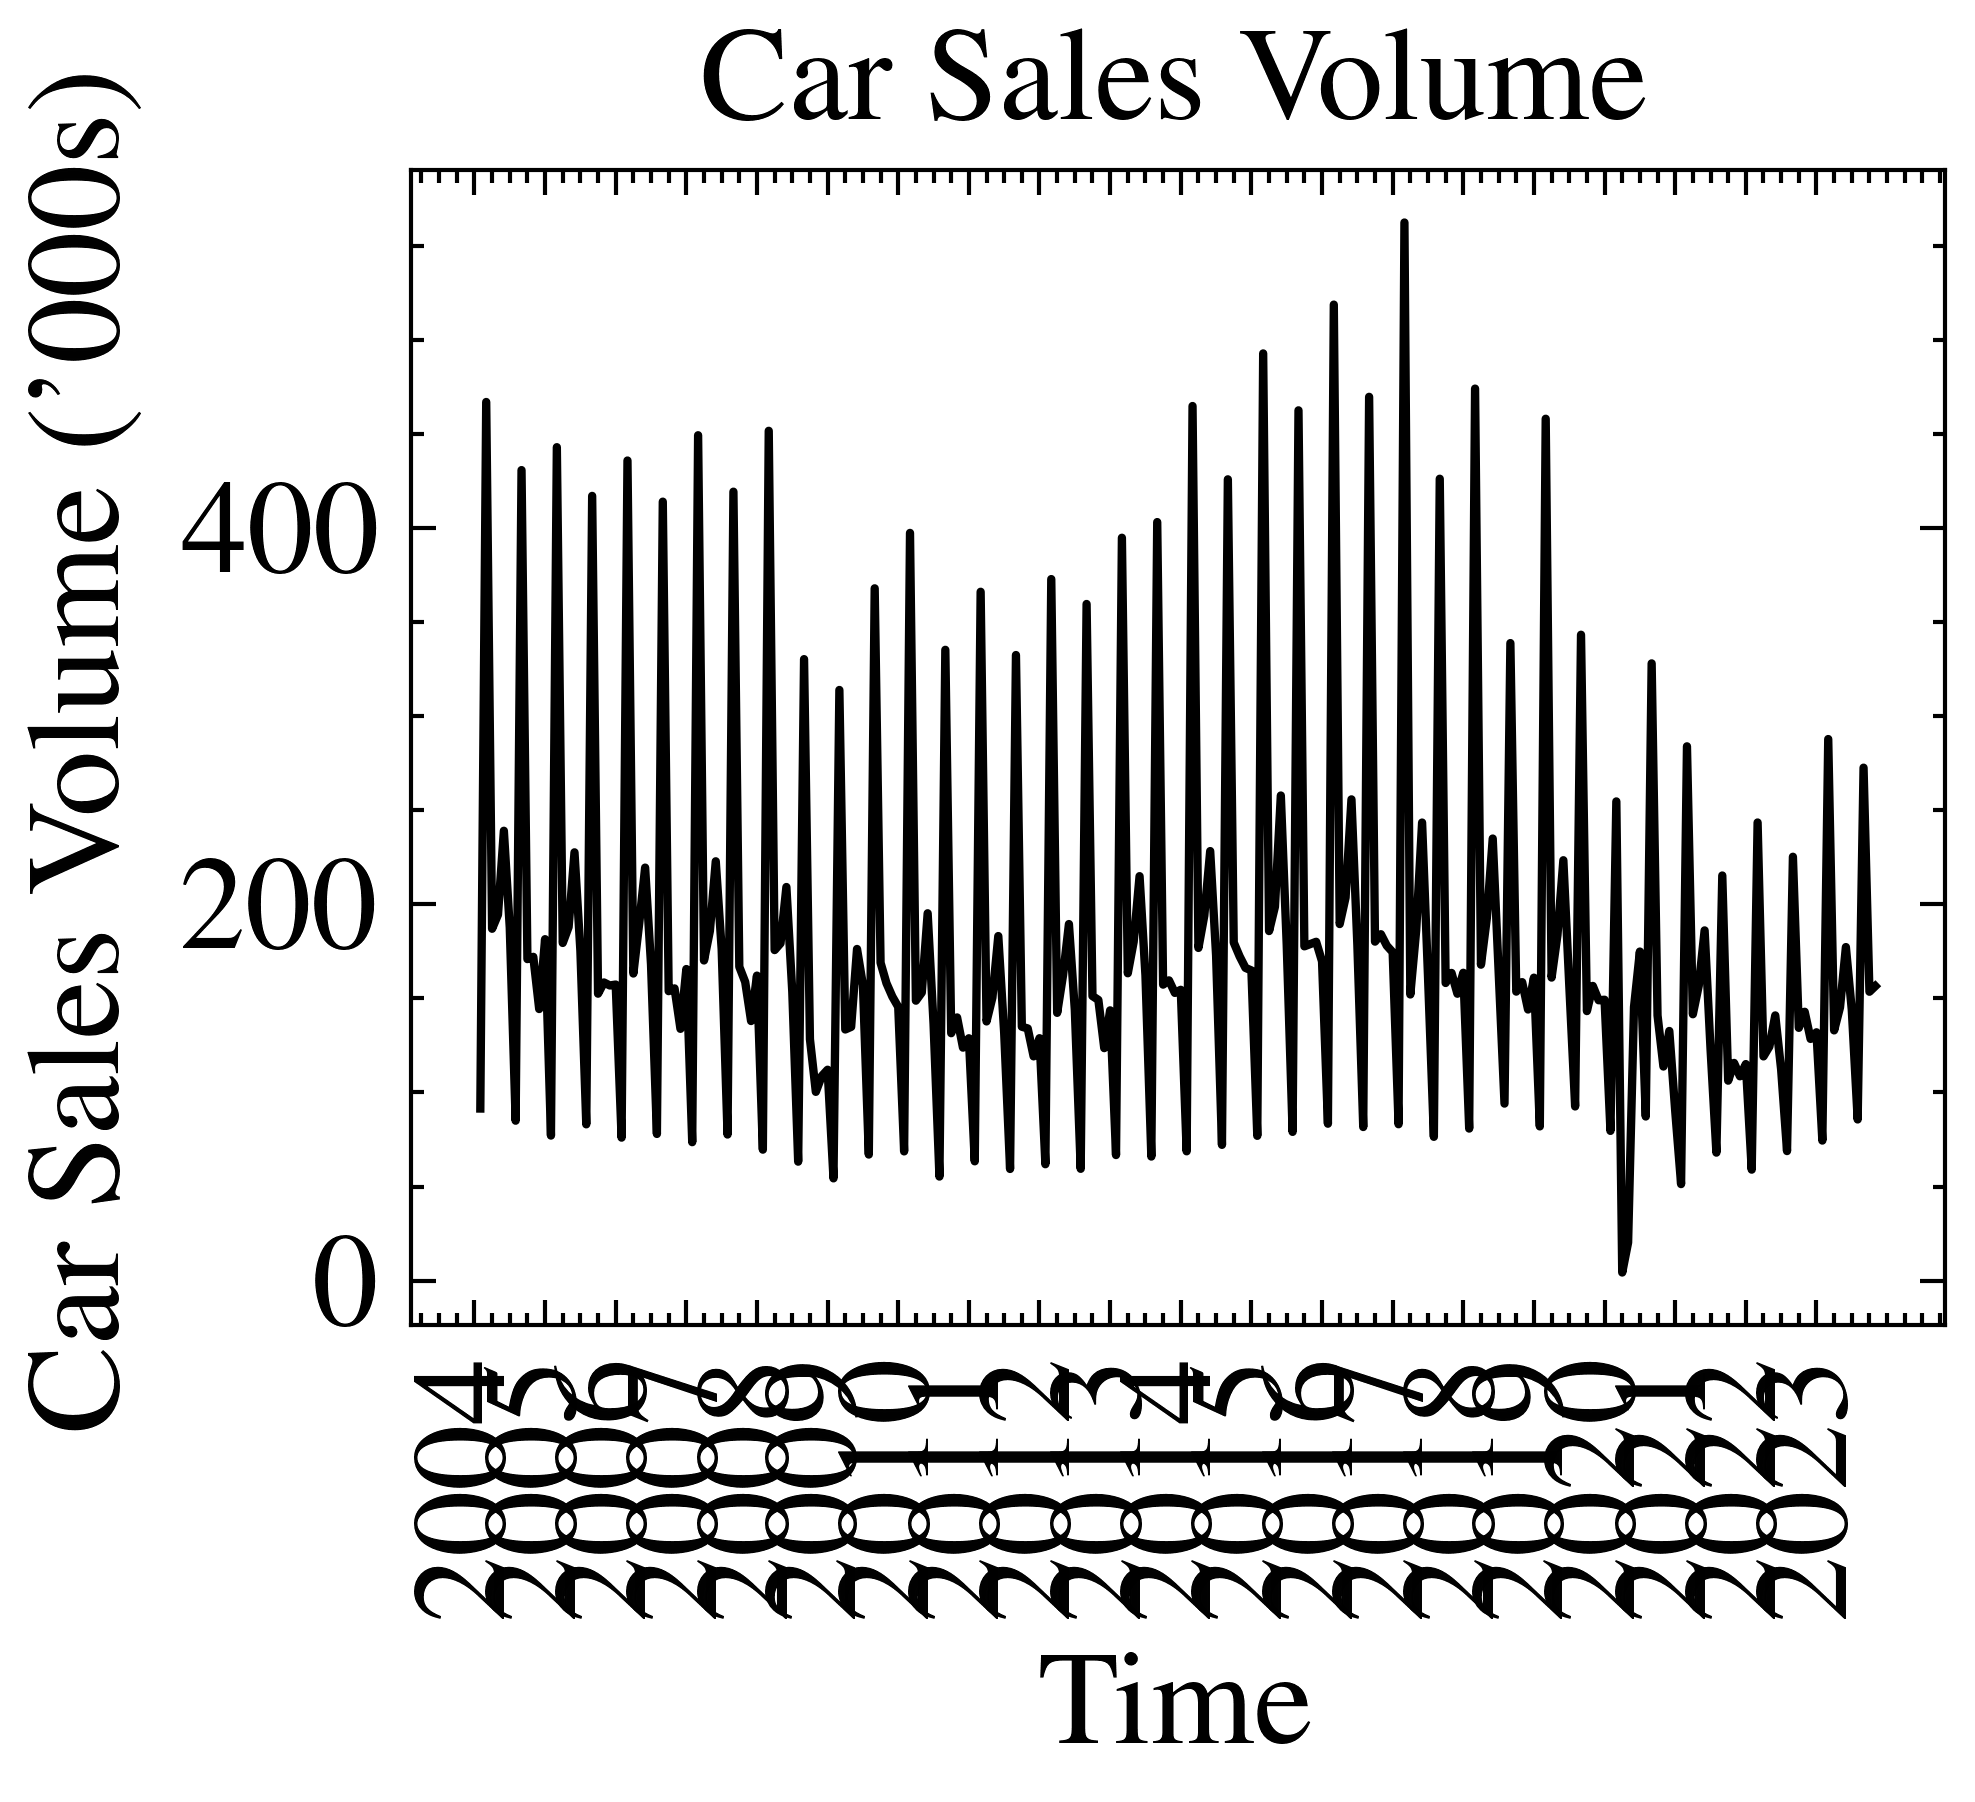

In [348]:
# plot for car sales to illustrate the cyclical/season nature of the variable

indicators['car'] = pd.to_numeric(indicators['car'], errors = 'coerce')


plt.plot(indicators['car'], color = 'black')
plt.title("Car Sales Volume")
plt.xticks(january_indices, labels = years, rotation = 'vertical')
plt.xlabel('Time')
plt.ylabel("Car Sales Volume ('000s)")
plt.show()

In [324]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
